In [ ]:
!pip install causalml

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from causalml.inference.meta import LRSRegressor,BaseSRegressor
from xgboost import XGBRegressor

In [4]:
data1 = pd.read_csv('/content/drive/MyDrive/Discount_Sales Project/customers.csv')
data1.head()

,CustomerKey,BirthDate,Education,Gender,MaritalStatus,Occupation,Sum of YearlyIncome,Sum of DiscountAmount,Sum of DiscountQuantity,Sum of SalesAmount,Sum of SalesQuantity,Average of UnitPrice
0,1,1966-04-08 00:00:00,Bachelors,M,M,Professional,90000,NaN,NaN,NaN,NaN,NaN
1,2,1965-05-14 00:00:00,Bachelors,M,S,Professional,60000,NaN,NaN,NaN,NaN,NaN
2,3,1965-08-12 00:00:00,Bachelors,M,M,Professional,60000,41.99,4.0,197.97,4.0,59.99
3,4,1968-02-15 00:00:00,Bachelors,F,S,Professional,70000,0.00,0.0,59.99,1.0,59.99
4,5,1968-08-08 00:00:00,Bachelors,F,S,Professional,80000,21.00,2.0,158.97,3.0,59.99


In [5]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18484 entries, 0 to 18483
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CustomerKey              18484 non-null  int64  
 1   BirthDate                18484 non-null  object 
 2   Education                18484 non-null  object 
 3   Gender                   18484 non-null  object 
 4   MaritalStatus            18484 non-null  object 
 5   Occupation               18484 non-null  object 
 6   Sum of YearlyIncome      18484 non-null  int64  
 7   Sum of DiscountAmount    17647 non-null  float64
 8   Sum of DiscountQuantity  17647 non-null  float64
 9   Sum of SalesAmount       17647 non-null  float64
 10  Sum of SalesQuantity     17647 non-null  float64
 11  Average of UnitPrice     17647 non-null  float64
dtypes: float64(5), int64(2), object(5)
memory usage: 1.7+ MB


### Feature Engineering

* Rename all the variables having 'sum' in the name
* Generate Age of the consumer
* Remove null values

In [6]:
# Rename columns

newnames = {'Sum of YearlyIncome':'Income','Sum of DiscountAmount':'DiscountAmt','Sum of DiscountQuantity':'DiscountQty','Average of UnitPrice':'Price',
            'Sum of SalesAmount':'Sales','Sum of SalesQuantity':'Quantity'}
data1.rename(columns=newnames,inplace=True)

In [7]:
# Generate Age for the customers

import datetime

def from_dob_to_age(born):
    today = datetime.date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

In [8]:
data1['BirthDate'] =  pd.to_datetime(data1['BirthDate'])
data1['Age']=data1['BirthDate'].apply(lambda x: from_dob_to_age(x))

In [9]:
# Drop missing values

df = data1.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17647 entries, 2 to 18483
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   CustomerKey    17647 non-null  int64         
 1   BirthDate      17647 non-null  datetime64[ns]
 2   Education      17647 non-null  object        
 3   Gender         17647 non-null  object        
 4   MaritalStatus  17647 non-null  object        
 5   Occupation     17647 non-null  object        
 6   Income         17647 non-null  int64         
 7   DiscountAmt    17647 non-null  float64       
 8   DiscountQty    17647 non-null  float64       
 9   Sales          17647 non-null  float64       
 10  Quantity       17647 non-null  float64       
 11  Price          17647 non-null  float64       
 12  Age            17647 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(3), object(4)
memory usage: 1.9+ MB


In [10]:
# create numerical and categorical variables

df_num = df.select_dtypes(exclude='object')
df_obj = df.select_dtypes(include='object')

In [11]:
# Convert df_obj to dummy variables

df_obj = pd.get_dummies(df_obj,drop_first=True,prefix_sep=('*'))

In [12]:
# combine numerical and categorical data

df_data=pd.concat([df_num,df_obj],axis=1)

In [13]:
df_data = df_data.join(df_data[['Age','Income']]**2,rsuffix="^2")
df_data.head()

,CustomerKey,BirthDate,Income,DiscountAmt,DiscountQty,Sales,Quantity,Price,Age,Education*Graduate Degree,...,Education*Partial College,Education*Partial High School,Gender*M,MaritalStatus*S,Occupation*Management,Occupation*Manual,Occupation*Professional,Occupation*Skilled Manual,Age^2,Income^2
2,3,1965-08-12,60000,41.99,4.0,197.97,4.0,59.99,57,0,...,0,0,1,0,0,0,1,0,3249,3600000000
3,4,1968-02-15,70000,0.00,0.0,59.99,1.0,59.99,54,0,...,0,0,0,1,0,0,1,0,2916,4900000000
4,5,1968-08-08,80000,21.00,2.0,158.97,3.0,59.99,54,0,...,0,0,0,1,0,0,1,0,2916,6400000000
5,6,1965-08-05,70000,21.00,2.0,98.98,2.0,59.99,57,0,...,0,0,1,1,0,0,1,0,3249,4900000000
6,7,1965-12-06,70000,9.00,1.0,50.99,1.0,59.99,56,0,...,0,0,0,1,0,0,1,0,3136,4900000000


In [14]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17647 entries, 2 to 18483
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   CustomerKey                    17647 non-null  int64         
 1   BirthDate                      17647 non-null  datetime64[ns]
 2   Income                         17647 non-null  int64         
 3   DiscountAmt                    17647 non-null  float64       
 4   DiscountQty                    17647 non-null  float64       
 5   Sales                          17647 non-null  float64       
 6   Quantity                       17647 non-null  float64       
 7   Price                          17647 non-null  float64       
 8   Age                            17647 non-null  int64         
 9   Education*Graduate Degree      17647 non-null  uint8         
 10  Education*High School          17647 non-null  uint8         
 11  Education*Parti

In [15]:
# Rename columns with longer names

namesdf = {'Education*Graduate Degree':'graduate','Education*High School':'HighSchool','Education*Partial College':'PartialCollege',
           'Education*Partial High School':'PartialHighSc','Gender*M':'Male','MaritalStatus*S':'Single','Occupation*Management':'ManagerCdr',
           'Occupation*Manual':'ManualCdr','Occupation*Professional':'ProfessionalCdr','Occupation*Skilled Manual':'SkilledManualCdr'}

df_data1 = df_data.rename(columns=namesdf) 

In [16]:
df_data1.columns

Index(['CustomerKey', 'BirthDate', 'Income', 'DiscountAmt', 'DiscountQty',
       'Sales', 'Quantity', 'Price', 'Age', 'graduate', 'HighSchool',
       'PartialCollege', 'PartialHighSc', 'Male', 'Single', 'ManagerCdr',
       'ManualCdr', 'ProfessionalCdr', 'SkilledManualCdr', 'Age^2',
       'Income^2'],
      dtype='object')

### Create Sampling data 
We shall draw out control sample from those with zero discount while the tretment group will be those with 2 unique discounts may be 4 and 6 %

In [17]:
df_data1['DiscPerc'] = round(df_data1['DiscountAmt']/df_data1['Sales'],2)

In [18]:
df_data1['DiscPerc'].value_counts()

0.05    2852
0.08    2273
0.00    1780
0.04    1576
0.11    1342
0.03    1325
0.07    1113
0.06    1010
0.02     683
0.09     590
0.10     491
0.18     470
0.14     383
0.13     371
0.25     277
0.12     238
0.15     224
0.16     141
0.01     126
0.21     116
0.20      99
0.19      67
0.17      55
0.22      25
0.23       9
inf        4
0.31       1
Name: DiscPerc, dtype: int64

We shall select 3 groups of customers, 
* Those with 0.00
* Those with 0.05
* Those with 0.10

In [19]:
# Population Sampling

Control_pop = df_data1.query('DiscPerc==0.00')
Treatment_pop1 = df_data1.query('DiscPerc==0.05')
Treatment_pop2 = df_data1.query('DiscPerc==0.10')

In [20]:
Control_pop.shape,Treatment_pop1.shape,Treatment_pop2.shape

((1780, 22), (2852, 22), (491, 22))

In [21]:
# take a sample of 1000 from control, 700 from treatment1 and 450 from treatment2

control_sample = Control_pop.sample(n=1000,random_state=42)
treatment_sample1 = Treatment_pop1.sample(n=700,random_state=42)
treatment_sample2 = Treatment_pop2.sample(n=450,random_state=42)

In [22]:
# Create treatment column and join the data

treatment_sample1['treatment']='treatment1'
control_sample['treatment']='control'
treatment_sample2['treatment']='treatment2'

### Create 2 dataframes
 Create 2 sets of data, 1 for control and treatment1, and another 1 for control and all the treatments

In [23]:
dataset = pd.concat([control_sample,treatment_sample1,treatment_sample2],axis=0)

In [24]:
dataset.shape

(2150, 23)

In [25]:
dataset.head()

,CustomerKey,BirthDate,Income,DiscountAmt,DiscountQty,Sales,Quantity,Price,Age,graduate,...,Male,Single,ManagerCdr,ManualCdr,ProfessionalCdr,SkilledManualCdr,Age^2,Income^2,DiscPerc,treatment
17792,17793,1958-03-09,40000,0.0,0.0,59.99,1.0,59.99,64,0,...,1,1,0,0,0,0,4096,1600000000,0.0,control
15729,15730,1953-01-12,70000,0.0,0.0,119.98,2.0,59.99,69,1,...,1,1,1,0,0,0,4761,4900000000,0.0,control
13633,13634,1940-09-13,60000,0.0,0.0,59.99,1.0,59.99,82,0,...,1,0,1,0,0,0,6724,3600000000,0.0,control
14426,14427,1966-03-22,70000,0.0,0.0,119.98,2.0,59.99,56,1,...,1,1,0,0,1,0,3136,4900000000,0.0,control
18153,18154,1960-03-17,40000,0.0,0.0,119.98,2.0,59.99,62,0,...,1,1,0,0,1,0,3844,1600000000,0.0,control


### Analysis of 5% discount population

In [26]:
dataset['treatment'].value_counts()

control       1000
treatment1     700
treatment2     450
Name: treatment, dtype: int64

In [27]:
data = dataset.query("treatment!='treatment2'")

In [28]:
data.shape

(1700, 23)

In [61]:
dataset.to_csv("customer_df_set.csv")

In [30]:
data['treatment'].value_counts()

control       1000
treatment1     700
Name: treatment, dtype: int64

In [31]:
data['treatment'].value_counts()

control       1000
treatment1     700
Name: treatment, dtype: int64

In [32]:
data.columns

Index(['CustomerKey', 'BirthDate', 'Income', 'DiscountAmt', 'DiscountQty',
       'Sales', 'Quantity', 'Price', 'Age', 'graduate', 'HighSchool',
       'PartialCollege', 'PartialHighSc', 'Male', 'Single', 'ManagerCdr',
       'ManualCdr', 'ProfessionalCdr', 'SkilledManualCdr', 'Age^2', 'Income^2',
       'DiscPerc', 'treatment'],
      dtype='object')

In [33]:
feature_names =['Income','Price', 'Age', 'graduate', 'HighSchool',
       'PartialCollege', 'PartialHighSc', 'Male', 'Single', 'ManagerCdr',
       'ManualCdr', 'ProfessionalCdr', 'SkilledManualCdr', 'Age^2', 'Income^2',
       ]

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1700 entries, 17792 to 7352
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerKey       1700 non-null   int64         
 1   BirthDate         1700 non-null   datetime64[ns]
 2   Income            1700 non-null   int64         
 3   DiscountAmt       1700 non-null   float64       
 4   DiscountQty       1700 non-null   float64       
 5   Sales             1700 non-null   float64       
 6   Quantity          1700 non-null   float64       
 7   Price             1700 non-null   float64       
 8   Age               1700 non-null   int64         
 9   graduate          1700 non-null   uint8         
 10  HighSchool        1700 non-null   uint8         
 11  PartialCollege    1700 non-null   uint8         
 12  PartialHighSc     1700 non-null   uint8         
 13  Male              1700 non-null   uint8         
 14  Single            17

In [36]:
X = data[feature_names]
y = data['Sales']
treatment = data['treatment']

In [37]:
pd.Series(treatment).value_counts()

control       1000
treatment1     700
Name: treatment, dtype: int64

In [38]:
from lightgbm import LGBMRegressor

In [39]:
base_algo = LGBMRegressor()
slearner = BaseSRegressor(base_algo,control_name='control')
slearner.estimate_ate(X,treatment,y)


array([79.49197533])

In [40]:
ite = slearner.fit_predict(X,treatment,y)

In [41]:
# True ATE

ite.mean()

79.49197533403807

In [48]:
treat = treatment.map({'treatment1':1,'control':0})

In [49]:
treat.value_counts()

0    1000
1     700
Name: treatment, dtype: int64

In [50]:
xgb = BaseSRegressor(XGBRegressor(random_state=42))
te,lb,ub = xgb.estimate_ate(X,treat,y,return_ci=True)

[22:09:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [53]:
print('Average Treatment Effect (Linear Regression):{:.2f} ({:.2f},{:.2f}))'.format(te[0],lb[0],ub[0]))

Average Treatment Effect (Linear Regression):78.93 (72.04,85.82))


In [54]:
xgb.get_importance(X=X,tau=ite,normalize=True,method='auto',features=feature_names)

{1: Price               0.418589
 Income              0.221571
 Age                 0.152557
 ManualCdr           0.050764
 Male                0.042815
 ProfessionalCdr     0.041431
 Single              0.024889
 SkilledManualCdr    0.020985
 HighSchool          0.010916
 PartialCollege      0.006925
 graduate            0.003445
 ManagerCdr          0.003404
 PartialHighSc       0.001710
 Age^2               0.000000
 Income^2            0.000000
 dtype: float64}

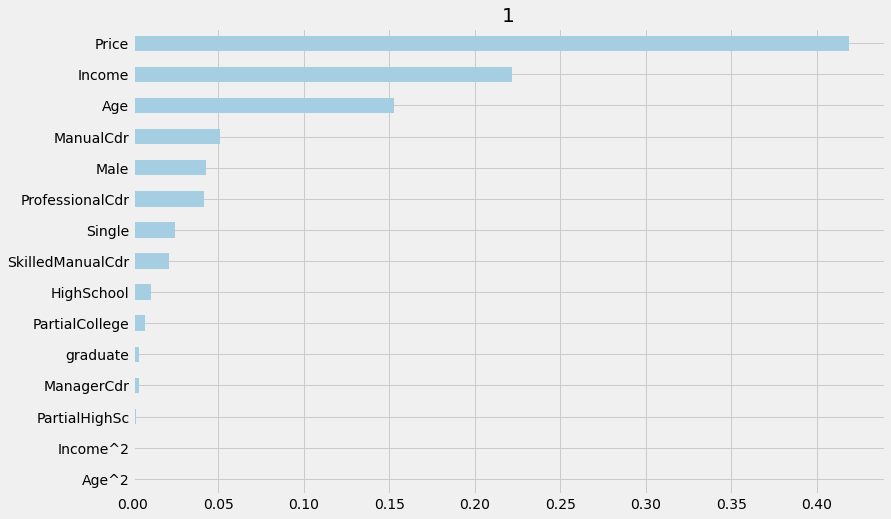

In [55]:
xgb.plot_importance(X=X,tau=ite,normalize=True,method='auto',features=feature_names)

In [56]:
sharp_slearner = slearner.get_shap_values(X=X,tau=ite)
sharp_slearner

{'treatment1': array([[ 24.11513879,   4.55636434,   2.74458962, ...,  -0.59788321,
           0.        ,   0.        ],
        [-42.56777512,   1.75951665,  -9.8587475 , ...,  -1.93258167,
           0.        ,   0.        ],
        [-29.18017585,   2.70211821,   7.7150349 , ...,  -0.3224747 ,
           0.        ,   0.        ],
        ...,
        [-35.91490768,   1.80396187,  -7.6979158 , ...,   5.80223066,
           0.        ,   0.        ],
        [ 28.93397406, -53.52584744,   0.47171908, ...,  -2.11202313,
           0.        ,   0.        ],
        [-24.80370166,   2.32532017,   3.74088363, ...,   1.21986539,
           0.        ,   0.        ]])}

In [57]:
np.mean(np.abs(sharp_slearner['treatment1']),axis=0)

array([27.65839838,  9.54841668, 11.22134126,  1.1440451 ,  1.21834311,
        1.2156911 ,  0.91916182,  5.35165556,  4.00934471,  0.35641413,
        5.38172596,  5.73728092,  2.57900854,  0.        ,  0.        ])

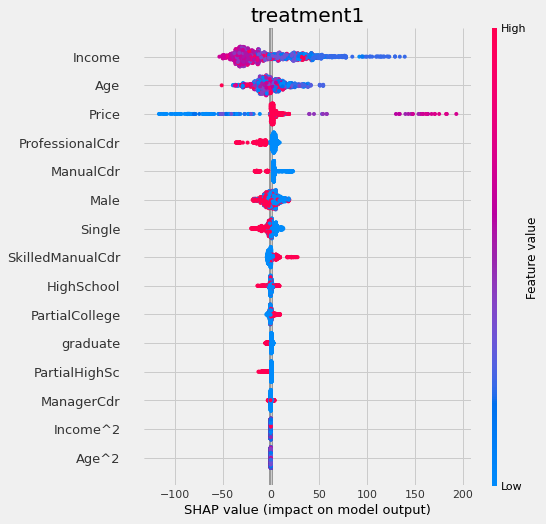

In [59]:
slearner.plot_shap_values(X=X,tau=ite,features=feature_names)

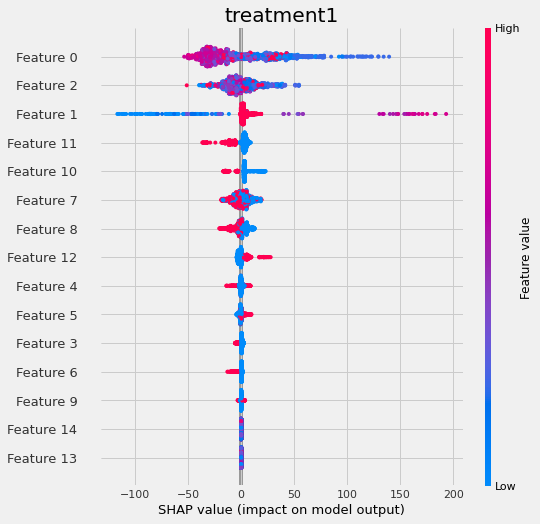

In [60]:
slearner.plot_shap_values(X=X,shap_dict=sharp_slearner)